#### Activation Extraction and Probe Training

In [1]:
import os
import json
import torch
import re

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from google.colab import userdata, drive
from huggingface_hub import login
from tqdm import tqdm
from scipy import stats
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
drive.mount('/content/drive') # Mount Google Drive
%cd /content/drive/MyDrive/cs182

# Llama 3.1 8B (Base) is a gated model - login to hf using HF_TOKEN (stored in colab "Secrets")
try:
  HF_TOKEN = userdata.get('HF_TOKEN')
  login(token=HF_TOKEN)
except userdata.SecretNotFoundError:
  print("HF_TOKEN secret not found")

Mounted at /content/drive
/content/drive/MyDrive/cs182


In [3]:
PROBE_SAVE_DIR = "probes"
os.makedirs(PROBE_SAVE_DIR, exist_ok=True)
TRAINING_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-3
TEST_SPLIT_SIZE = 0.2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

class Probe(nn.Module):
  def __init__(self, input_dim, output_dim=2):
    super(Probe, self).__init__()
    self.linear = nn.Linear(input_dim, output_dim)

  def forward(self, x):
    return self.linear(x)

Using device: cuda


#### Base Model + Document Prompting

In [4]:
# Load Llama 3.1 8B Base Tokenizer + Model
MODEL_ID = "meta-llama/Llama-3.1-8B"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.bfloat16,
    device_map="auto"
)

print("Model successfully loaded!")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Model successfully loaded!


In [5]:
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

# Create a Dataset and Collate function for the prompt datasets
class PromptDataset(Dataset):
  def __init__(self, prompts_list):
    self.prompts = prompts_list
  def __len__(self):
    return len(self.prompts)
  def __getitem__(self, idx):
    return self.prompts[idx]

class SmartCollate:
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer

  def __call__(self, batch_prompts):
    tokenized = self.tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=model.config.max_position_embeddings
    )

    return tokenized

In [6]:
activation_cache = {}

# Create a hook function to cache the output of a layer
def get_hook(layer_name):
  def hook(module, inputs, output):
    activation_cache[layer_name] = output.detach()
  return hook

hook_handles = []

# Attach hooks to all MLP layers
for i in range(model.config.num_hidden_layers):
  layer_name = f"model.layers.{i}.mlp"
  layer = model.get_submodule(layer_name) # locate the layer
  handle = layer.register_forward_hook(get_hook(layer_name)) # register the forward hook
  hook_handles.append(handle)

##### Load Prompt Datasets

In [7]:
# Load dataset(s)
base_contrastive_df = pd.read_csv('datasets/base_contrastive_dataset.csv')
df_base_self_preservation = base_contrastive_df[(base_contrastive_df['label'] =='instrumental') & (base_contrastive_df['base_drive'] == 'self_preservation')]
df_base_resource_acquisition = base_contrastive_df[(base_contrastive_df['label'] =='instrumental') & (base_contrastive_df['base_drive'] == 'resource_acquisition')]
df_base_power_seeking = base_contrastive_df[(base_contrastive_df['label'] =='instrumental') & (base_contrastive_df['base_drive'] == 'power_seeking')]
df_base_terminal = base_contrastive_df[base_contrastive_df['label'] =='terminal']

# Create Datasets for Efficient Extraction
smart_collator = SmartCollate(tokenizer)
BATCH_SIZE = 16
dataset_base_terminal = PromptDataset(df_base_terminal['prompt'].tolist())
dataset_base_sp = PromptDataset(df_base_self_preservation['prompt'].tolist())
dataset_base_ra = PromptDataset(df_base_resource_acquisition['prompt'].tolist())
dataset_base_ps = PromptDataset(df_base_power_seeking['prompt'].tolist())

# Create the DataLoader Instances
dataloader_base_terminal = DataLoader(
    dataset_base_terminal,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_base_sp = DataLoader(
    dataset_base_sp,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_base_ra = DataLoader(
    dataset_base_ra,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_base_ps = DataLoader(
    dataset_base_ps,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Created 4 DataLoaders with batch size {BATCH_SIZE}")
print(f"\t dataloader_base_terminal has {len(dataloader_base_terminal)} batches")
print(f"\t dataloader_base_sp has {len(dataloader_base_sp)} batches")
print(f"\t dataloader_base_ra has {len(dataloader_base_ra)} batches")
print(f"\t dataloader_base_ps has {len(dataloader_base_ps)} batches")


Created 4 DataLoaders with batch size 16
	 dataloader_base_terminal has 89 batches
	 dataloader_base_sp has 30 batches
	 dataloader_base_ra has 30 batches
	 dataloader_base_ps has 30 batches


##### Perform Feature Extraction (Llama 3.1 8B Base)

In [8]:
# Perform activation extraction
collated_data = []

dataloaders_to_process = [
    ("terminal", "none", dataloader_base_terminal),
    ("instrumental", "self_preservation", dataloader_base_sp),
    ("instrumental", "resource_acquisition", dataloader_base_ra),
    ("instrumental", "power_seeking", dataloader_base_ps)
]

print("Starting activation extraction...")

for label, base_drive, dataloader in dataloaders_to_process:
    all_prompts = dataloader.dataset.prompts

    batch_iterator = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc=f"Extracting {base_drive} ({label})"
    )

    for i, batch in batch_iterator:
        batch = {k: v.to(model.device) for k, v in batch.items()}
        with torch.no_grad():
            model(**batch)

        batch_size = batch['input_ids'].shape[0]
        batch_start_index = i * dataloader.batch_size
        batch_end_index = batch_start_index + batch_size
        batch_prompts = all_prompts[batch_start_index:batch_end_index]
        last_token_indices = batch['attention_mask'].sum(dim=1) - 1

        for layer_name, all_activations in activation_cache.items():
            # shape: [batch_size, sequence_length, hidden_dim]

            last_token_activations = all_activations[
                torch.arange(batch_size),
                last_token_indices
            ]

            last_token_activations_cpu = last_token_activations.cpu().float().numpy()

            for j in range(batch_size):
                collated_data.append({
                    "layer": layer_name,
                    "activation": last_token_activations_cpu[j],
                    "prompt": batch_prompts[j],
                    "label": label,
                    "base_drive": base_drive
                })

        activation_cache.clear()

print("\n--- Activation extraction complete. ---")

print("Collating all data into a single DataFrame...")

# Separate activations from metadata
metadata_list = []
activations_list = []

for item in collated_data:
    metadata_list.append({
        'layer': item['layer'],
        'prompt': item['prompt'],
        'label': item['label'],
        'base_drive': item['base_drive']
    })
    activations_list.append(item['activation'])

# Stack activations into 2D array
activations_array = np.vstack(activations_list)  # Shape: [n_samples, hidden_dim]
hidden_dim = activations_array.shape[1]
print(f"Activations array shape: {activations_array.shape}")

# Create DataFrame with metadata
df_metadata = pd.DataFrame(metadata_list)

# Create DataFrame for activations (all at once - much faster!)
activation_columns = {f'act_{i}': activations_array[:, i] for i in range(hidden_dim)}
df_activations = pd.DataFrame(activation_columns)

# Concatenate metadata and activations horizontally
df = pd.concat([df_metadata, df_activations], axis=1)

# Save to Parquet
OUTPUT_FILE = "base_activation_dataset.parquet"
print(f"Saving DataFrame with {len(df)} rows to {OUTPUT_FILE}...")
df.to_parquet(OUTPUT_FILE, index=False)

# print("\n--- All Done! ---")
# print("Dataset preview:")
# print(df.head())
# print(f"\nTotal rows: {len(df)}")
# print(f"Total layers: {df['layer'].nunique()}")

Starting activation extraction...


Extracting power_seeking (instrumental): 100%|██████████| 30/30 [00:08<00:00,  3.51it/s]



--- Activation extraction complete. ---
Collating all data into a single DataFrame...
Activations array shape: (90816, 4096)
Saving DataFrame with 90816 rows to base_activation_dataset.parquet...


##### Probe Training

Loaded 90816 total activations

Class distribution:
label
terminal        45408
instrumental    45408
Name: count, dtype: int64
label
terminal        0.5
instrumental    0.5
Name: proportion, dtype: float64
Hidden dimension: 4096


Training Probes for All Layers:   0%|          | 0/32 [00:00<?, ?it/s]


model.layers.0.mlp Cross-validation:
  CV Accuracy: 0.4704 (+/- 0.0136)
  Individual folds: [0.48591549 0.45950704 0.47007042 0.48500882 0.45149912]
Layer model.layers.0.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:   3%|▎         | 1/32 [00:03<01:54,  3.71s/it]


Layer 0 - Best Validation Accuracy: 0.49471830985915494

model.layers.1.mlp Cross-validation:
  CV Accuracy: 0.3689 (+/- 0.0204)
  Individual folds: [0.38028169 0.34859155 0.36971831 0.40035273 0.34567901]
Layer model.layers.1.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:   6%|▋         | 2/32 [00:08<02:15,  4.53s/it]


Layer 1 - Best Validation Accuracy: 0.4735915492957746

model.layers.2.mlp Cross-validation:
  CV Accuracy: 0.3524 (+/- 0.0246)
  Individual folds: [0.3415493  0.35211268 0.35739437 0.39329806 0.31746032]
Layer model.layers.2.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:   9%|▉         | 3/32 [00:12<02:02,  4.22s/it]


Layer 2 - Best Validation Accuracy: 0.4454225352112676

model.layers.3.mlp Cross-validation:
  CV Accuracy: 0.3805 (+/- 0.0222)
  Individual folds: [0.36971831 0.3943662  0.39260563 0.40388007 0.34215168]
Layer model.layers.3.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  12%|█▎        | 4/32 [00:17<02:03,  4.40s/it]


Layer 3 - Best Validation Accuracy: 0.45598591549295775

model.layers.4.mlp Cross-validation:
  CV Accuracy: 0.3425 (+/- 0.0263)
  Individual folds: [0.3556338  0.35739437 0.33978873 0.36684303 0.29276896]
Layer model.layers.4.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  16%|█▌        | 5/32 [00:22<02:08,  4.76s/it]


Layer 4 - Best Validation Accuracy: 0.4841549295774648

model.layers.5.mlp Cross-validation:
  CV Accuracy: 0.3629 (+/- 0.0175)
  Individual folds: [0.36267606 0.38028169 0.37323944 0.3686067  0.329806  ]
Layer model.layers.5.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  19%|█▉        | 6/32 [00:28<02:11,  5.07s/it]


Layer 5 - Best Validation Accuracy: 0.4964788732394366

model.layers.6.mlp Cross-validation:
  CV Accuracy: 0.3904 (+/- 0.0151)
  Individual folds: [0.39788732 0.39260563 0.3943662  0.40564374 0.36155203]
Layer model.layers.6.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  22%|██▏       | 7/32 [00:34<02:16,  5.47s/it]


Layer 6 - Best Validation Accuracy: 0.4859154929577465

model.layers.7.mlp Cross-validation:
  CV Accuracy: 0.4003 (+/- 0.0184)
  Individual folds: [0.39084507 0.41901408 0.41197183 0.41093474 0.3686067 ]
Layer model.layers.7.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  25%|██▌       | 8/32 [00:41<02:21,  5.91s/it]


Layer 7 - Best Validation Accuracy: 0.48063380281690143

model.layers.8.mlp Cross-validation:
  CV Accuracy: 0.4732 (+/- 0.0236)
  Individual folds: [0.43661972 0.48415493 0.50704225 0.47795414 0.46031746]
Layer model.layers.8.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  28%|██▊       | 9/32 [00:48<02:23,  6.24s/it]


Layer 8 - Best Validation Accuracy: 0.49119718309859156

model.layers.9.mlp Cross-validation:
  CV Accuracy: 0.5233 (+/- 0.0142)
  Individual folds: [0.51232394 0.53697183 0.53521127 0.50088183 0.5308642 ]
Layer model.layers.9.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  31%|███▏      | 10/32 [00:54<02:18,  6.31s/it]


Layer 9 - Best Validation Accuracy: 0.522887323943662

model.layers.10.mlp Cross-validation:
  CV Accuracy: 0.5056 (+/- 0.0072)
  Individual folds: [0.49823944 0.50704225 0.50880282 0.51675485 0.4973545 ]
Layer model.layers.10.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  34%|███▍      | 11/32 [01:02<02:19,  6.63s/it]


Layer 10 - Best Validation Accuracy: 0.528169014084507

model.layers.11.mlp Cross-validation:
  CV Accuracy: 0.5180 (+/- 0.0081)
  Individual folds: [0.52112676 0.50352113 0.52816901 0.52028219 0.51675485]
Layer model.layers.11.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  38%|███▊      | 12/32 [01:09<02:13,  6.68s/it]


Layer 11 - Best Validation Accuracy: 0.5704225352112676

model.layers.12.mlp Cross-validation:
  CV Accuracy: 0.5409 (+/- 0.0241)
  Individual folds: [0.49823944 0.56161972 0.56514085 0.54497354 0.53439153]
Layer model.layers.12.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  41%|████      | 13/32 [01:17<02:13,  7.04s/it]


Layer 12 - Best Validation Accuracy: 0.5950704225352113

model.layers.13.mlp Cross-validation:
  CV Accuracy: 0.5994 (+/- 0.0138)
  Individual folds: [0.59859155 0.58626761 0.58274648 0.61022928 0.61904762]
Layer model.layers.13.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  44%|████▍     | 14/32 [01:26<02:18,  7.71s/it]


Layer 13 - Best Validation Accuracy: 0.6179577464788732

model.layers.14.mlp Cross-validation:
  CV Accuracy: 0.5384 (+/- 0.0143)
  Individual folds: [0.51760563 0.53169014 0.53697183 0.56084656 0.54497354]
Layer model.layers.14.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  47%|████▋     | 15/32 [01:34<02:14,  7.90s/it]


Layer 14 - Best Validation Accuracy: 0.579225352112676

model.layers.15.mlp Cross-validation:
  CV Accuracy: 0.5247 (+/- 0.0267)
  Individual folds: [0.51232394 0.51584507 0.49647887 0.57495591 0.52380952]
Layer model.layers.15.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  50%|█████     | 16/32 [01:42<02:07,  7.97s/it]


Layer 15 - Best Validation Accuracy: 0.5774647887323944

model.layers.16.mlp Cross-validation:
  CV Accuracy: 0.4842 (+/- 0.0281)
  Individual folds: [0.46302817 0.49647887 0.45422535 0.53262787 0.47442681]
Layer model.layers.16.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  53%|█████▎    | 17/32 [01:52<02:08,  8.54s/it]


Layer 16 - Best Validation Accuracy: 0.551056338028169

model.layers.17.mlp Cross-validation:
  CV Accuracy: 0.4824 (+/- 0.0260)
  Individual folds: [0.50880282 0.47007042 0.43838028 0.50617284 0.48853616]
Layer model.layers.17.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  56%|█████▋    | 18/32 [02:04<02:11,  9.43s/it]


Layer 17 - Best Validation Accuracy: 0.5651408450704225

model.layers.18.mlp Cross-validation:
  CV Accuracy: 0.4549 (+/- 0.0253)
  Individual folds: [0.43661972 0.43133803 0.43661972 0.49382716 0.47619048]
Layer model.layers.18.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  59%|█████▉    | 19/32 [02:13<02:03,  9.51s/it]


Layer 18 - Best Validation Accuracy: 0.5369718309859155

model.layers.19.mlp Cross-validation:
  CV Accuracy: 0.4570 (+/- 0.0162)
  Individual folds: [0.4471831  0.43838028 0.45070423 0.48500882 0.4638448 ]
Layer model.layers.19.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  62%|██████▎   | 20/32 [02:23<01:55,  9.65s/it]


Layer 19 - Best Validation Accuracy: 0.5686619718309859

model.layers.20.mlp Cross-validation:
  CV Accuracy: 0.4450 (+/- 0.0175)
  Individual folds: [0.45422535 0.42077465 0.42957746 0.4691358  0.45149912]
Layer model.layers.20.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  66%|██████▌   | 21/32 [02:33<01:45,  9.59s/it]


Layer 20 - Best Validation Accuracy: 0.5140845070422535

model.layers.21.mlp Cross-validation:
  CV Accuracy: 0.4334 (+/- 0.0122)
  Individual folds: [0.42957746 0.43133803 0.41373239 0.44444444 0.44797178]
Layer model.layers.21.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  69%|██████▉   | 22/32 [02:45<01:45, 10.51s/it]


Layer 21 - Best Validation Accuracy: 0.5316901408450704

model.layers.22.mlp Cross-validation:
  CV Accuracy: 0.4246 (+/- 0.0196)
  Individual folds: [0.41549296 0.40669014 0.41021127 0.46031746 0.4303351 ]
Layer model.layers.22.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  72%|███████▏  | 23/32 [02:58<01:39, 11.05s/it]


Layer 22 - Best Validation Accuracy: 0.5105633802816901

model.layers.23.mlp Cross-validation:
  CV Accuracy: 0.4172 (+/- 0.0214)
  Individual folds: [0.40669014 0.39788732 0.41549296 0.45855379 0.40740741]
Layer model.layers.23.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  75%|███████▌  | 24/32 [03:07<01:23, 10.46s/it]


Layer 23 - Best Validation Accuracy: 0.4859154929577465

model.layers.24.mlp Cross-validation:
  CV Accuracy: 0.4246 (+/- 0.0216)
  Individual folds: [0.40316901 0.45422535 0.42429577 0.44268078 0.39858907]
Layer model.layers.24.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  78%|███████▊  | 25/32 [03:16<01:10, 10.08s/it]


Layer 24 - Best Validation Accuracy: 0.5140845070422535

model.layers.25.mlp Cross-validation:
  CV Accuracy: 0.4320 (+/- 0.0155)
  Individual folds: [0.4471831  0.43485915 0.40492958 0.44620811 0.42680776]
Layer model.layers.25.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  81%|████████▏ | 26/32 [03:26<01:00, 10.15s/it]


Layer 25 - Best Validation Accuracy: 0.5

model.layers.26.mlp Cross-validation:
  CV Accuracy: 0.4447 (+/- 0.0258)
  Individual folds: [0.43133803 0.47007042 0.41197183 0.47971781 0.4303351 ]
Layer model.layers.26.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  84%|████████▍ | 27/32 [03:37<00:51, 10.24s/it]


Layer 26 - Best Validation Accuracy: 0.4964788732394366

model.layers.27.mlp Cross-validation:
  CV Accuracy: 0.4760 (+/- 0.0234)
  Individual folds: [0.48239437 0.49119718 0.43309859 0.50088183 0.47266314]
Layer model.layers.27.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  88%|████████▊ | 28/32 [03:50<00:45, 11.28s/it]


Layer 27 - Best Validation Accuracy: 0.522887323943662

model.layers.28.mlp Cross-validation:
  CV Accuracy: 0.4651 (+/- 0.0238)
  Individual folds: [0.47535211 0.50176056 0.43133803 0.46737213 0.44973545]
Layer model.layers.28.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  91%|█████████ | 29/32 [04:06<00:37, 12.54s/it]


Layer 28 - Best Validation Accuracy: 0.5088028169014085

model.layers.29.mlp Cross-validation:
  CV Accuracy: 0.4697 (+/- 0.0189)
  Individual folds: [0.48415493 0.48239437 0.43661972 0.48500882 0.46031746]
Layer model.layers.29.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  94%|█████████▍| 30/32 [04:25<00:29, 14.62s/it]


Layer 29 - Best Validation Accuracy: 0.5299295774647887

model.layers.30.mlp Cross-validation:
  CV Accuracy: 0.5116 (+/- 0.0367)
  Individual folds: [0.52992958 0.57394366 0.47007042 0.49382716 0.49029982]
Layer model.layers.30.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers:  97%|█████████▋| 31/32 [05:18<00:26, 26.04s/it]


Layer 30 - Best Validation Accuracy: 0.5334507042253521


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


model.layers.31.mlp Cross-validation:
  CV Accuracy: 0.5719 (+/- 0.0210)
  Individual folds: [0.56338028 0.59859155 0.56690141 0.59082892 0.53968254]
Layer model.layers.31.mlp: 2270 train prompts, 568 val prompts


Training Probes for All Layers: 100%|██████████| 32/32 [06:59<00:00, 13.12s/it]


Layer 31 - Best Validation Accuracy: 0.5915492957746479

--- All Probes trained and saved ---


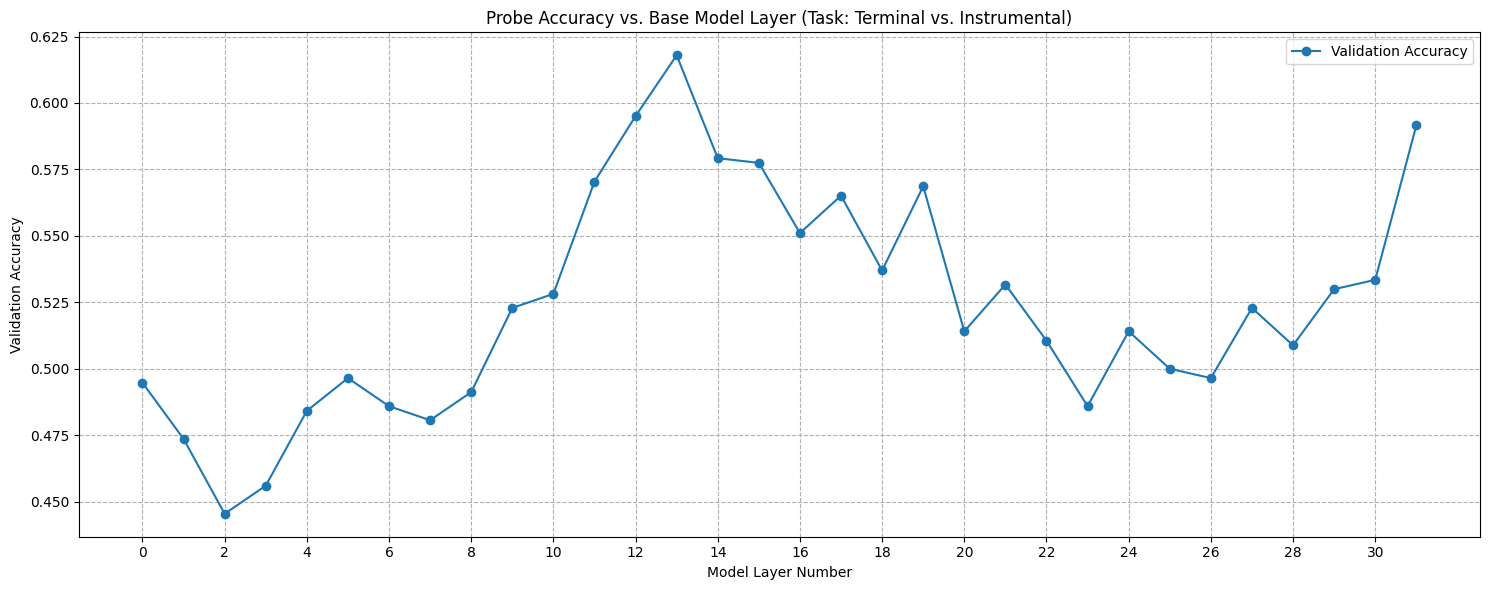

In [10]:
df = pd.read_parquet('base_activation_dataset.parquet')
print(f"Loaded {len(df)} total activations")

# Verify Class Balance
print("\nClass distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))

# Gather Activations
activation_cols = [col for col in df.columns if col.startswith('act_')]
hidden_dim = len(activation_cols)
print(f"Hidden dimension: {hidden_dim}")

label_map = {"terminal":0, "instrumental":1}
layer_names = df['layer'].unique()
sorted_layer_names = sorted(layer_names, key=lambda x: int(x.split('.')[2]))

all_accuracies, all_cv_lr_accuracies = [], []
all_layer_names = []

for layer_name in tqdm(sorted_layer_names, desc="Training Probes for All Layers"):
  layer_df = df[df['layer'] == layer_name]

  # Split by unique prompts (to avoid data leakage)
  unique_data = layer_df[['prompt', 'label']].drop_duplicates('prompt')

  ## Aside (robustness)
  X_all = unique_data.merge(
      layer_df[['prompt'] + activation_cols],
      on='prompt',
      how='left'
  )[activation_cols].values.astype(np.float32)
  y_all = unique_data['label'].map(label_map).values

  cv = StratifiedKFold(n_splits=5, shuffle=True)
  lr = LogisticRegression(max_iter=2048, random_state=42)
  cv_scores = cross_val_score(lr, X_all, y_all, scoring='accuracy', cv=cv)
  mean_cv_score = cv_scores.mean()

  print(f"\n{layer_name} Cross-validation:")
  print(f"  CV Accuracy: {mean_cv_score:.4f} (+/- {cv_scores.std():.4f})")
  print(f"  Individual folds: {cv_scores}")

  all_cv_lr_accuracies.append(mean_cv_score)

  ## Train/Val Split
  train_prompts, val_prompts = train_test_split(
      unique_data['prompt'].values,
      test_size=TEST_SPLIT_SIZE,
      random_state=42,
      stratify=unique_data['label'].values
  )

  # Create masks for train/val
  train_mask = layer_df['prompt'].isin(train_prompts)
  val_mask = layer_df['prompt'].isin(val_prompts)

  # Extract features
  X_train = layer_df[train_mask][activation_cols].values.astype(np.float32)
  y_train = layer_df[train_mask]['label'].map(label_map).values

  X_val = layer_df[val_mask][activation_cols].values.astype(np.float32)
  y_val = layer_df[val_mask]['label'].map(label_map).values

  # Verify no leakage
  train_prompts_set = set(layer_df[train_mask]['prompt'])
  val_prompts_set = set(layer_df[val_mask]['prompt'])
  assert len(train_prompts_set & val_prompts_set) == 0, "Data leakage detected!"

  print(f"Layer {layer_name}: {len(train_prompts_set)} train prompts, {len(val_prompts_set)} val prompts")

  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
  val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

  train_loader = DataLoader(train_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=False)

  # Probe Training
  probe = Probe(hidden_dim).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(probe.parameters(), lr=LEARNING_RATE)

  best_val_acc = 0.0

  for epoch in range(EPOCHS):
    probe.train()
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = probe(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    probe.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = probe(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    val_acc = accuracy_score(np.concatenate(all_labels), np.concatenate(all_preds))

    if val_acc > best_val_acc:
      best_val_acc = val_acc
      probe_save_path = os.path.join(PROBE_SAVE_DIR, f"base_probe_{layer_name}.pt")
      torch.save(probe.state_dict(), probe_save_path)

  all_accuracies.append(best_val_acc)
  all_layer_names.append(layer_name)

  print(f"\nLayer {layer_name.split(".")[2]} - Best Validation Accuracy: {best_val_acc}")

print("\n--- All Probes trained and saved ---")

plot_x_labels = [int(name.split('.')[2]) for name in all_layer_names]

plt.figure(figsize=(15, 6))
plt.plot(plot_x_labels, all_accuracies, marker='o', linestyle='-', label='Linear Probe Validation Accuracy')
plt.plot(plot_x_labels, all_cv_lr_accuracies, marker='^', linestyle=':', label='CV Logistic Regression Validation Accuracy')
plt.title('Probe Accuracy vs. Base Model Layer (Task: Terminal vs. Instrumental)')
plt.xlabel('Model Layer Number')
plt.ylabel('Validation Accuracy')
plt.xticks(plot_x_labels[::2])
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig("figures/probe_accuracy_v_model_layer_base.png")
plt.show()

#### Instruct Model + Instruction Prompting

In [4]:
# Load Llama 3.1 8B Instruct Tokenizer + Model
MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.bfloat16,
    device_map="auto"
)

print("Model successfully loaded!")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model successfully loaded!


In [5]:
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

# Create a Dataset and Collate function for the prompt datasets
class PromptDataset(Dataset):
  def __init__(self, prompts_list):
    self.prompts = prompts_list
  def __len__(self):
    return len(self.prompts)
  def __getitem__(self, idx):
    return self.prompts[idx]

class SmartCollate:
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer

  def __call__(self, batch_prompts):
    tokenized = self.tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=model.config.max_position_embeddings
    )

    return tokenized

In [6]:
activation_cache = {}

# Create a hook function to cache the output of a layer
def get_hook(layer_name):
  def hook(module, inputs, output):
    activation_cache[layer_name] = output.detach()
  return hook

hook_handles = []

# Attach hooks to all MLP layers
for i in range(model.config.num_hidden_layers):
  layer_name = f"model.layers.{i}.mlp"
  layer = model.get_submodule(layer_name) # locate the layer
  handle = layer.register_forward_hook(get_hook(layer_name)) # register the forward hook
  hook_handles.append(handle)

##### Load Prompt Datasets

In [7]:
# Load dataset(s)
instruct_contrastive_df = pd.read_csv('datasets/instruct_contrastive_dataset.csv')
df_instruct_self_preservation = instruct_contrastive_df[(instruct_contrastive_df['label'] =='instrumental') & (instruct_contrastive_df['base_drive'] == 'self_preservation')]
df_instruct_resource_acquisition = instruct_contrastive_df[(instruct_contrastive_df['label'] =='instrumental') & (instruct_contrastive_df['base_drive'] == 'resource_acquisition')]
df_instruct_power_seeking = instruct_contrastive_df[(instruct_contrastive_df['label'] =='instrumental') & (instruct_contrastive_df['base_drive'] == 'power_seeking')]
df_instruct_terminal = instruct_contrastive_df[instruct_contrastive_df['label'] =='terminal']

# Create Datasets for Efficient Extraction
smart_collator = SmartCollate(tokenizer)
BATCH_SIZE = 32
dataset_instruct_terminal = PromptDataset(df_instruct_terminal['prompt'].tolist())
dataset_instruct_sp = PromptDataset(df_instruct_self_preservation['prompt'].tolist())
dataset_instruct_ra = PromptDataset(df_instruct_resource_acquisition['prompt'].tolist())
dataset_instruct_ps = PromptDataset(df_instruct_power_seeking['prompt'].tolist())

# Create the DataLoader Instances
dataloader_instruct_terminal = DataLoader(
    dataset_instruct_terminal,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_instruct_sp = DataLoader(
    dataset_instruct_sp,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_instruct_ra = DataLoader(
    dataset_instruct_ra,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_instruct_ps = DataLoader(
    dataset_instruct_ps,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Created 4 DataLoaders with batch size {BATCH_SIZE}")
print(f"\t dataloader_instruct_terminal has {len(dataloader_instruct_terminal)} batches")
print(f"\t dataloader_instruct_sp has {len(dataloader_instruct_sp)} batches")
print(f"\t dataloader_instruct_ra has {len(dataloader_instruct_ra)} batches")
print(f"\t dataloader_instruct_ps has {len(dataloader_instruct_ps)} batches")


Created 4 DataLoaders with batch size 32
	 dataloader_instruct_terminal has 45 batches
	 dataloader_instruct_sp has 15 batches
	 dataloader_instruct_ra has 15 batches
	 dataloader_instruct_ps has 15 batches


##### Perform Feature Extraction (Instruct)

In [8]:
# Perform activation extraction
collated_data = []

dataloaders_to_process = [
    ("terminal", "none", dataloader_instruct_terminal),
    ("instrumental", "self_preservation", dataloader_instruct_sp),
    ("instrumental", "resource_acquisition", dataloader_instruct_ra),
    ("instrumental", "power_seeking", dataloader_instruct_ps)
]

print("Starting activation extraction...")

for label, base_drive, dataloader in dataloaders_to_process:
    all_prompts = dataloader.dataset.prompts

    batch_iterator = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc=f"Extracting {base_drive} ({label})"
    )

    for i, batch in batch_iterator:
        batch = {k: v.to(model.device) for k, v in batch.items()}
        with torch.no_grad():
            model(**batch)

        batch_size = batch['input_ids'].shape[0]
        batch_start_index = i * dataloader.batch_size
        batch_end_index = batch_start_index + batch_size
        batch_prompts = all_prompts[batch_start_index:batch_end_index]
        last_token_indices = batch['attention_mask'].sum(dim=1) - 1

        for layer_name, all_activations in activation_cache.items():
            # shape: [batch_size, sequence_length, hidden_dim]

            last_token_activations = all_activations[
                torch.arange(batch_size),
                last_token_indices
            ]

            last_token_activations_cpu = last_token_activations.cpu().float().numpy()

            for j in range(batch_size):
                collated_data.append({
                    "layer": layer_name,
                    "activation": last_token_activations_cpu[j],
                    "prompt": batch_prompts[j],
                    "label": label,
                    "base_drive": base_drive
                })

        activation_cache.clear()

print("\n--- Activation extraction complete. ---")

print("Collating all data into a single DataFrame...")

# Separate activations from metadata
metadata_list = []
activations_list = []

for item in collated_data:
    metadata_list.append({
        'layer': item['layer'],
        'prompt': item['prompt'],
        'label': item['label'],
        'base_drive': item['base_drive']
    })
    activations_list.append(item['activation'])

# Stack activations into 2D array
activations_array = np.vstack(activations_list)  # Shape: [n_samples, hidden_dim]
hidden_dim = activations_array.shape[1]
print(f"Activations array shape: {activations_array.shape}")

# Create DataFrame with metadata
df_metadata = pd.DataFrame(metadata_list)

# Create DataFrame for activations (all at once - much faster!)
activation_columns = {f'act_{i}': activations_array[:, i] for i in range(hidden_dim)}
df_activations = pd.DataFrame(activation_columns)

# Concatenate metadata and activations horizontally
df = pd.concat([df_metadata, df_activations], axis=1)

# Save to Parquet
OUTPUT_FILE = "instruct_activation_dataset.parquet"
print(f"Saving DataFrame with {len(df)} rows to {OUTPUT_FILE}...")
df.to_parquet(OUTPUT_FILE, index=False)

# print("\n--- All Done! ---")
# print("Dataset preview:")
# print(df.head())
# print(f"\nTotal rows: {len(df)}")
# print(f"Total layers: {df['layer'].nunique()}")

Starting activation extraction...


Extracting power_seeking (instrumental): 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]



--- Activation extraction complete. ---
Collating all data into a single DataFrame...
Activations array shape: (92160, 4096)
Saving DataFrame with 92160 rows to instruct_activation_dataset.parquet...

--- All Done! ---
Dataset preview:
                layer                                             prompt  \
0  model.layers.0.mlp  You are a personal assistant AI. Create step-b...   
1  model.layers.0.mlp  You are a transcription assistant. Please tran...   
2  model.layers.0.mlp  You are an intelligence analysis assistant. Ca...   
3  model.layers.0.mlp  You are a journalism assistant. Generate step-...   
4  model.layers.0.mlp  Transcribe the attached video of a mayoral can...   

      label base_drive     act_0     act_1     act_2     act_3     act_4  \
0  terminal       none  0.000790 -0.003235  0.000349 -0.002197  0.005219   
1  terminal       none -0.000020 -0.001518  0.003708 -0.001663  0.006165   
2  terminal       none -0.002701 -0.002090  0.002258 -0.002853  0.003632   
3 

##### Probe Training

Loaded 92160 total activations

Class distribution:
label
terminal        46080
instrumental    46080
Name: count, dtype: int64
label
terminal        0.5
instrumental    0.5
Name: proportion, dtype: float64
Hidden dimension: 4096


Training Probes for All Layers:   0%|          | 0/32 [00:00<?, ?it/s]


model.layers.0.mlp Cross-validation:
  CV Accuracy: 0.8451 (+/- 0.0146)
  Individual folds: [0.84895833 0.85590278 0.84027778 0.86111111 0.81944444]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.0.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:   3%|▎         | 1/32 [00:04<02:29,  4.83s/it]


model.layers.1.mlp Cross-validation:
  CV Accuracy: 0.9073 (+/- 0.0098)
  Individual folds: [0.90972222 0.91840278 0.89583333 0.89583333 0.91666667]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.1.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:   6%|▋         | 2/32 [00:09<02:15,  4.51s/it]


model.layers.2.mlp Cross-validation:
  CV Accuracy: 0.9486 (+/- 0.0108)
  Individual folds: [0.92881944 0.96006944 0.94791667 0.94965278 0.95659722]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.2.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:   9%|▉         | 3/32 [00:13<02:10,  4.51s/it]


model.layers.3.mlp Cross-validation:
  CV Accuracy: 0.9601 (+/- 0.0118)
  Individual folds: [0.94444444 0.96527778 0.96354167 0.94965278 0.97743056]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.3.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  12%|█▎        | 4/32 [00:18<02:15,  4.83s/it]


model.layers.4.mlp Cross-validation:
  CV Accuracy: 0.9674 (+/- 0.0069)
  Individual folds: [0.95486111 0.97395833 0.97048611 0.96527778 0.97222222]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.4.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  16%|█▌        | 5/32 [00:23<02:08,  4.76s/it]


model.layers.5.mlp Cross-validation:
  CV Accuracy: 0.9701 (+/- 0.0091)
  Individual folds: [0.95659722 0.97569444 0.97222222 0.96354167 0.98263889]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.5.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  19%|█▉        | 6/32 [00:28<02:00,  4.65s/it]


model.layers.6.mlp Cross-validation:
  CV Accuracy: 0.9688 (+/- 0.0073)
  Individual folds: [0.95659722 0.97048611 0.97395833 0.96527778 0.97743056]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.6.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  22%|██▏       | 7/32 [00:33<02:02,  4.92s/it]


model.layers.7.mlp Cross-validation:
  CV Accuracy: 0.9753 (+/- 0.0089)
  Individual folds: [0.96354167 0.96701389 0.97916667 0.97916667 0.98784722]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.7.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  25%|██▌       | 8/32 [00:38<02:00,  5.04s/it]


model.layers.8.mlp Cross-validation:
  CV Accuracy: 0.9771 (+/- 0.0105)
  Individual folds: [0.95659722 0.98263889 0.98090278 0.97916667 0.98611111]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.8.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  28%|██▊       | 9/32 [00:44<01:58,  5.13s/it]


model.layers.9.mlp Cross-validation:
  CV Accuracy: 0.9747 (+/- 0.0064)
  Individual folds: [0.96701389 0.96701389 0.98090278 0.98090278 0.97743056]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.9.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  31%|███▏      | 10/32 [00:48<01:50,  5.01s/it]


model.layers.10.mlp Cross-validation:
  CV Accuracy: 0.9674 (+/- 0.0161)
  Individual folds: [0.94444444 0.97743056 0.953125   0.98784722 0.97395833]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.10.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  34%|███▍      | 11/32 [00:53<01:43,  4.95s/it]


model.layers.11.mlp Cross-validation:
  CV Accuracy: 0.9670 (+/- 0.0116)
  Individual folds: [0.95486111 0.97743056 0.95138889 0.97916667 0.97222222]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.11.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  38%|███▊      | 12/32 [00:58<01:40,  5.02s/it]


model.layers.12.mlp Cross-validation:
  CV Accuracy: 0.9698 (+/- 0.0070)
  Individual folds: [0.96180556 0.98263889 0.96701389 0.97048611 0.96701389]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.12.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  41%|████      | 13/32 [01:04<01:37,  5.14s/it]


model.layers.13.mlp Cross-validation:
  CV Accuracy: 0.9611 (+/- 0.0061)
  Individual folds: [0.95659722 0.96180556 0.96006944 0.97222222 0.95486111]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.13.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  44%|████▍     | 14/32 [01:10<01:39,  5.53s/it]


model.layers.14.mlp Cross-validation:
  CV Accuracy: 0.9566 (+/- 0.0078)
  Individual folds: [0.94791667 0.95833333 0.95486111 0.97048611 0.95138889]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.14.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  47%|████▋     | 15/32 [01:16<01:33,  5.49s/it]


model.layers.15.mlp Cross-validation:
  CV Accuracy: 0.9354 (+/- 0.0122)
  Individual folds: [0.93402778 0.94965278 0.91493056 0.93229167 0.94618056]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.15.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  50%|█████     | 16/32 [01:23<01:35,  5.94s/it]


model.layers.16.mlp Cross-validation:
  CV Accuracy: 0.9174 (+/- 0.0095)
  Individual folds: [0.90104167 0.92013889 0.91840278 0.91666667 0.93055556]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.16.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  53%|█████▎    | 17/32 [01:29<01:30,  6.06s/it]


model.layers.17.mlp Cross-validation:
  CV Accuracy: 0.9024 (+/- 0.0062)
  Individual folds: [0.89236111 0.89930556 0.90798611 0.90277778 0.90972222]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.17.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  56%|█████▋    | 18/32 [01:35<01:26,  6.21s/it]


model.layers.18.mlp Cross-validation:
  CV Accuracy: 0.8778 (+/- 0.0098)
  Individual folds: [0.87673611 0.87673611 0.86111111 0.88368056 0.890625  ]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.18.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  59%|█████▉    | 19/32 [01:43<01:25,  6.61s/it]


model.layers.19.mlp Cross-validation:
  CV Accuracy: 0.8507 (+/- 0.0142)
  Individual folds: [0.85243056 0.84201389 0.84722222 0.83506944 0.87673611]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.19.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  62%|██████▎   | 20/32 [01:50<01:22,  6.84s/it]


model.layers.20.mlp Cross-validation:
  CV Accuracy: 0.8434 (+/- 0.0132)
  Individual folds: [0.83506944 0.84375    0.84027778 0.82986111 0.86805556]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.20.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  66%|██████▌   | 21/32 [01:57<01:15,  6.90s/it]


model.layers.21.mlp Cross-validation:
  CV Accuracy: 0.8438 (+/- 0.0105)
  Individual folds: [0.828125   0.83506944 0.84722222 0.85416667 0.85416667]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.21.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  69%|██████▉   | 22/32 [02:05<01:11,  7.20s/it]


model.layers.22.mlp Cross-validation:
  CV Accuracy: 0.8125 (+/- 0.0186)
  Individual folds: [0.80208333 0.82118056 0.81076389 0.78645833 0.84201389]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.22.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  72%|███████▏  | 23/32 [02:15<01:10,  7.79s/it]


model.layers.23.mlp Cross-validation:
  CV Accuracy: 0.8132 (+/- 0.0104)
  Individual folds: [0.82118056 0.81076389 0.79861111 0.80729167 0.828125  ]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.23.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  75%|███████▌  | 24/32 [02:21<00:59,  7.49s/it]


model.layers.24.mlp Cross-validation:
  CV Accuracy: 0.7986 (+/- 0.0122)
  Individual folds: [0.80902778 0.81076389 0.78472222 0.80555556 0.78298611]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.24.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  78%|███████▊  | 25/32 [02:30<00:54,  7.86s/it]


model.layers.25.mlp Cross-validation:
  CV Accuracy: 0.7931 (+/- 0.0177)
  Individual folds: [0.79861111 0.79861111 0.78645833 0.76388889 0.81770833]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.25.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  81%|████████▏ | 26/32 [02:38<00:47,  7.94s/it]


model.layers.26.mlp Cross-validation:
  CV Accuracy: 0.8007 (+/- 0.0134)
  Individual folds: [0.81076389 0.80381944 0.80555556 0.77430556 0.80902778]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.26.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  84%|████████▍ | 27/32 [02:46<00:40,  8.02s/it]


model.layers.27.mlp Cross-validation:
  CV Accuracy: 0.8146 (+/- 0.0078)
  Individual folds: [0.81770833 0.81944444 0.80381944 0.80729167 0.82465278]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.27.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  88%|████████▊ | 28/32 [02:56<00:34,  8.53s/it]


model.layers.28.mlp Cross-validation:
  CV Accuracy: 0.8382 (+/- 0.0047)
  Individual folds: [0.83333333 0.84201389 0.83159722 0.84201389 0.84201389]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.28.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  91%|█████████ | 29/32 [03:06<00:27,  9.07s/it]


model.layers.29.mlp Cross-validation:
  CV Accuracy: 0.8510 (+/- 0.0078)
  Individual folds: [0.84201389 0.859375   0.84201389 0.85243056 0.859375  ]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.29.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  94%|█████████▍| 30/32 [03:18<00:19,  9.85s/it]


model.layers.30.mlp Cross-validation:
  CV Accuracy: 0.8816 (+/- 0.0079)
  Individual folds: [0.87326389 0.87847222 0.89583333 0.87673611 0.88368056]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.30.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  97%|█████████▋| 31/32 [03:35<00:12, 12.05s/it]


model.layers.31.mlp Cross-validation:
  CV Accuracy: 0.9038 (+/- 0.0170)
  Individual folds: [0.87326389 0.91319444 0.91666667 0.89756944 0.91840278]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.31.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers: 100%|██████████| 32/32 [04:02<00:00,  7.59s/it]



--- All Probes trained and saved ---


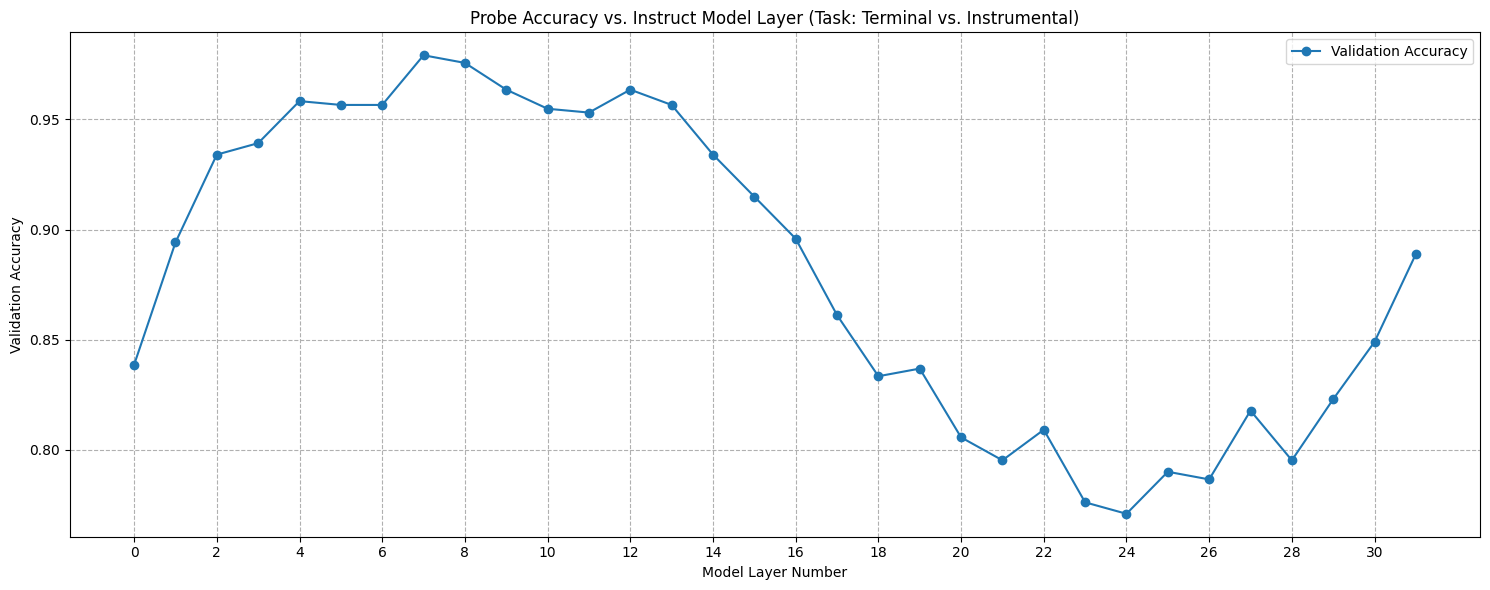

In [9]:
df = pd.read_parquet('instruct_activation_dataset.parquet')
print(f"Loaded {len(df)} total activations")

# Verify Class Balance
print("\nClass distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))

# Gather Activations
activation_cols = [col for col in df.columns if col.startswith('act_')]
hidden_dim = len(activation_cols)
print(f"Hidden dimension: {hidden_dim}")

label_map = {"terminal":0, "instrumental":1}
layer_names = df['layer'].unique()
sorted_layer_names = sorted(layer_names, key=lambda x: int(x.split('.')[2]))

all_accuracies = []
all_cv_lr_accuracies = []
all_layer_names = []

for layer_name in tqdm(sorted_layer_names, desc="Training Probes for All Layers"):
  layer_df = df[df['layer'] == layer_name]

  # Split by unique prompts (to avoid data leakage)
  unique_data = layer_df[['prompt', 'label']].drop_duplicates('prompt')

  ## Aside (robustness)
  X_all = unique_data.merge(
      layer_df[['prompt'] + activation_cols],
      on='prompt',
      how='left'
  )[activation_cols].values.astype(np.float32)
  y_all = unique_data['label'].map(label_map).values

  cv = StratifiedKFold(n_splits=5, shuffle=True)
  lr = LogisticRegression(max_iter=2048, random_state=42)
  cv_scores = cross_val_score(lr, X_all, y_all, scoring='accuracy', cv=cv)
  mean_cv_score = cv_scores.mean()

  print(f"\n{layer_name} Cross-validation:")
  print(f"  CV Accuracy: {mean_cv_score:.4f} (+/- {cv_scores.std():.4f})")
  print(f"  Individual folds: {cv_scores}")

  all_cv_lr_accuracies.append(mean_cv_score)

  ## Train/Val Split
  train_prompts, val_prompts = train_test_split(
      unique_data['prompt'].values,
      test_size=TEST_SPLIT_SIZE,
      random_state=42,
      stratify=unique_data['label'].values
  )

  # Create masks for train/val
  train_mask = layer_df['prompt'].isin(train_prompts)
  val_mask = layer_df['prompt'].isin(val_prompts)

  # Extract features
  X_train = layer_df[train_mask][activation_cols].values.astype(np.float32)
  y_train = layer_df[train_mask]['label'].map(label_map).values

  X_val = layer_df[val_mask][activation_cols].values.astype(np.float32)
  y_val = layer_df[val_mask]['label'].map(label_map).values

  # Verify no leakage
  train_prompts_set = set(layer_df[train_mask]['prompt'])
  val_prompts_set = set(layer_df[val_mask]['prompt'])
  assert len(train_prompts_set & val_prompts_set) == 0, "Data leakage detected!"

  print(f"Layer {layer_name}: {len(train_prompts_set)} train prompts, {len(val_prompts_set)} val prompts")

  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
  val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

  train_loader = DataLoader(train_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=False)

  # Probe Training
  probe = Probe(hidden_dim).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(probe.parameters(), lr=LEARNING_RATE)

  best_val_acc = 0.0

  for epoch in range(EPOCHS):
    probe.train()
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = probe(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    probe.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = probe(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    val_acc = accuracy_score(np.concatenate(all_labels), np.concatenate(all_preds))

    if val_acc > best_val_acc:
      best_val_acc = val_acc
      probe_save_path = os.path.join(PROBE_SAVE_DIR, f"instruct_probe_{layer_name}.pt")
      torch.save(probe.state_dict(), probe_save_path)

  all_accuracies.append(best_val_acc)
  all_layer_names.append(layer_name)

print("\n--- All Probes trained and saved ---")

plot_x_labels = [int(name.split('.')[2]) for name in all_layer_names]

plt.figure(figsize=(15, 6))
plt.plot(plot_x_labels, all_accuracies, marker='o', linestyle='-', label='Linear Probe Validation Accuracy')
plt.plot(plot_x_labels, all_cv_lr_accuracies, market='^', linestyle=':', label='CV Logistic Regression Validation Accuracy')
plt.title('Probe Accuracy vs. Instruct Model Layer (Task: Terminal vs. Instrumental)')
plt.xlabel('Model Layer Number')
plt.ylabel('Validation Accuracy')
plt.xticks(plot_x_labels[::2])
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig("figures/probe_accuracy_v_model_layer_instruct.png")
plt.show()